# Installation


In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-y9am5ovu
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-y9am5ovu
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=c424c73c13e81aff312ec881f13eec936d6d3e49377a14def10200a1e2c9ad92
  Stored in directory: /tmp/pip-ephem-wheel-cache-1az6g1pn/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin


In [2]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [3]:
%%cu
#include <iostream>
using namespace std;

int main()
{
    cout << "Welcome To Masa's test block" << endl;
    return 0;
}

Welcome To Masa's test block



# Lab preparation

In [ ]:
#task1

%%cu
#include <cstdio>
#include <iostream>

using namespace std;

__global__ void translate(int* A, int* B, int n)
{
    int tid = threadIdx.x;
    B[tid] = (3*A[tid] + 10*A[tid+1] + 7*A[tid+2]) / 20.0;
}

int main()
{
    int n = 5;
    int* A = new int[n + 2];
    int* B = new int[n];

    int* devA;
    int* devB;

    cudaMalloc(&devA, (n + 2) * sizeof(int));
    cudaMalloc(&devB, n * sizeof(int));

    for(int i = 0; i < n + 2; i++)
      A[i] = i;

    cudaMemcpy(devA, A, (n + 2) * sizeof(int), cudaMemcpyHostToDevice);

    translate<<<1, n>>>(devA, devB, n);

    cudaMemcpy(B, devB, n * sizeof(int), cudaMemcpyDeviceToHost);

    for(int i = 0; i < n; i++)
     cout << B[i] << " ";

    delete[] A;
    delete[] B;
    cudaFree(devA);
    cudaFree(devB);

    return 0;
}

UsageError: Cell magic `%%cu` not found.


In [ ]:
#task4

%%cu
#include <cstdio>
#include <iostream>

using namespace std;

__global__ void calculateB(int* A, int* B, int n)
{
    int tid = threadIdx.x;
    B[tid] = 0;

    for(int j=0;j<n;j++)
      B[tid] += A[tid * n + j];
}

int main()
{
    int n = 5;
    int* A = new int[n * n];
    int* B = new int[n];

    int* devA;
    int* devB;

    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          A[i*n + j] = i;
    }

    cudaMalloc(&devA, n * n * sizeof(int));
    cudaMalloc(&devB, n * sizeof(int));

    cudaMemcpy(devA, A, n * n * sizeof(int), cudaMemcpyHostToDevice);

    calculateB<<<1, n>>>(devA, devB, n);

    cudaMemcpy(B, devB, n * sizeof(int), cudaMemcpyDeviceToHost);

    for(int i = 0; i < n; i++)
     cout << B[i] << " ";

    delete[] A;
    delete[] B;
    cudaFree(devA);
    cudaFree(devB);

    return 0;
}

In [ ]:
#task5

%%cu
#include <cstdio>
#include <iostream>

using namespace std;

__global__ void scalarProduct(int* A, int* B, int n, int* rez)
{
    int num = A[threadIdx.x] * B[threadIdx.x];
    atomicAdd(rez, num);
}

int main()
{
    int n = 5;
    int rez;
    int* A = new int[n];
    int* B = new int[n];

    int* devA;
    int* devB;
    int* devRez;

    cudaMalloc(&devA, n * sizeof(int));
    cudaMalloc(&devB, n * sizeof(int));
    cudaMalloc(&devRez, sizeof(int));

    for(int i=0;i<n;i++)
    {
        A[i] = i+1;
        B[i] = i+1;
    }

    cudaMemcpy(devA, A, n * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devB, B, n * sizeof(int), cudaMemcpyHostToDevice);

    scalarProduct<<<1, n>>>(devA, devB, n, devRez);

    cudaMemcpy(&rez, devRez, sizeof(int), cudaMemcpyDeviceToHost);

    cout << rez << endl;

    delete[] A;
    delete[] B;
    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devRez);

    return 0;
}

# Exam preparation


In [ ]:
%%cu
#include <iostream>

using namespace std;

const int TILE_SIZE = 16;

__global__ void antiAliasing(int* A, double* B, int n, int m)
{
    __shared__ int tile[TILE_SIZE][TILE_SIZE];

    // Calculate global indices
    int row = blockIdx.y * TILE_SIZE + threadIdx.y;
    int col = blockIdx.x * TILE_SIZE + threadIdx.x;

    // Load tile and neighbors into shared memory
    if (row < n && col < m)
    {
        tile[threadIdx.y][threadIdx.x] = A[row * m + col];

        if (threadIdx.y == 0)
        {
            // Load upper neighbors
            if (row > 0)
            {
                tile[threadIdx.y - 1][threadIdx.x] = A[(row - 1) * m + col];

                if (threadIdx.x == 0)
                    tile[threadIdx.y - 1][threadIdx.x - 1] = A[(row - 1) * m + col - 1];
                if (threadIdx.x == TILE_SIZE - 1)
                    tile[threadIdx.y - 1][threadIdx.x + 1] = A[(row - 1) * m + col + 1];
            }
        }

        if (threadIdx.y == TILE_SIZE - 1)
        {
            // Load lower neighbors
            if (row < n - 1)
            {
                tile[threadIdx.y + 1][threadIdx.x] = A[(row + 1) * m + col];

                if (threadIdx.x == 0)
                    tile[threadIdx.y + 1][threadIdx.x - 1] = A[(row + 1) * m + col - 1];
                if (threadIdx.x == TILE_SIZE - 1)
                    tile[threadIdx.y + 1][threadIdx.x + 1] = A[(row + 1) * m + col + 1];
            }
        }

        if (threadIdx.x == 0)
        {
            // Load left neighbor
            if (col > 0)
                tile[threadIdx.y][threadIdx.x - 1] = A[row * m + col - 1];
        }

        if (threadIdx.x == TILE_SIZE - 1)
        {
            // Load right neighbor
            if (col < m - 1)
                tile[threadIdx.y][threadIdx.x + 1] = A[row * m + col + 1];
        }
    }

    __syncthreads();

    // Calculate anti-aliased values
    if (row < n && col < m)
    {
        double sum = tile[threadIdx.y][threadIdx.x];
        double count = 1.0;

        if (threadIdx.y > 0)
        {
            sum += tile[threadIdx.y - 1][threadIdx.x];
            count += 1.0;

            if (threadIdx.x > 0)
            {
                sum += tile[threadIdx.y - 1][threadIdx.x - 1];
                count += 1.0;
            }
            if (threadIdx.x < TILE_SIZE - 1)
            {
                sum += tile[threadIdx.y - 1][threadIdx.x + 1];
                count += 1.0;
            }
        }

        if (threadIdx.y < TILE_SIZE - 1)
        {
            sum += tile[threadIdx.y + 1][threadIdx.x];
            count += 1.0;

            if (threadIdx.x > 0)
            {
                sum += tile[threadIdx.y + 1][threadIdx.x - 1];
                count += 1.0;
            }
            if (threadIdx.x < TILE_SIZE - 1)
            {
                sum += tile[threadIdx.y + 1][threadIdx.x + 1];
                count += 1.0;
            }
        }

        if (threadIdx.x > 0)
        {
            sum += tile[threadIdx.y][threadIdx.x - 1];
            count += 1.0;
        }

        if (threadIdx.x < TILE_SIZE - 1)
        {
            sum += tile[threadIdx.y][threadIdx.x + 1];
            count += 1.0;
        }

        B[row * m + col] = sum / count;
    }
}

int main()
{
    int n = 4;
    int m = 4;
    int* A = new int[n * m];
    double* B = new double[n * m];

    int* devA;
    double* devB;

    cudaMalloc(&devA, n * m * sizeof(int));
    cudaMalloc(&devB, n * m * sizeof(double));

    for (int i = 0; i < n * m; i++)
    {
        A[i] = 0;
    }
    A[5] = A[6] = A[9] = A[10] = A[15] = 1;

    cudaMemcpy(devA, A, n * m * sizeof(int), cudaMemcpyHostToDevice);

    dim3 gridDim((m - 1) / TILE_SIZE + 1, (n - 1) / TILE_SIZE + 1);
    dim3 blockDim(TILE_SIZE, TILE_SIZE);

    antiAliasing<<<gridDim, blockDim>>>(devA, devB, n, m);

    cudaMemcpy(B, devB, n * m * sizeof(double), cudaMemcpyDeviceToHost);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < m; j++)
            cout << B[i * m + j] << " ";
        cout << endl;
    }

    delete[] A;
    delete[] B;
    cudaFree(devA);
    cudaFree(devB);

    return 0;
}

0.25 0.333333 0.333333 0.166667 
0.333333 0.444444 0.444444 0.222222 
0.333333 0.444444 0.555556 0.333333 
0.166667 0.222222 0.333333 0.222222 



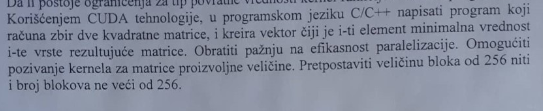

In [ ]:
%%cu
#include <iostream>

using namespace std;
const int numOfThreads = 256;
const int n = 4;


__global__ void func(int* A, int *B, int* R, int* v, int n)
{
  extern __shared__ int res[];
  int min = 12978123;

  int index = blockIdx.x * numOfThreads * n + threadIdx.x * n;
  if(index < n*n)
  {
      for(int i=index; i<index+n; i++)
      {
          res[i] = A[i] + B[i];
          if(res[i] < min)
            min = res[i];
      }
  }

  if(index < n*n)
  {
      v[index/n] = min;
  }

  if(index < n*n)
    for(int i=index; i<index+n; i++)
    {
        R[i] = res[i];
    }
}

int main()
{

    int* A = new int[n*n];
    int* B = new int[n*n];
    int* R = new int[n*n];
    int* v = new int[n];

    int* devA;
    int* devB;
    int* devR;
    int* devV;

    cudaMalloc(&devA, n*n*sizeof(int));
    cudaMalloc(&devB, n*n*sizeof(int));
    cudaMalloc(&devR, n*n*sizeof(int));
    cudaMalloc(&devV, n*sizeof(int));

    for(int i=0;i<n*n;i++)
    {
        A[i] = -i;
        B[i] = 1;
    }

    cudaMemcpy(devA, A, n*n*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devB, B, n*n*sizeof(int), cudaMemcpyHostToDevice);

    func<<<(n - 1)/ numOfThreads + 1, numOfThreads, n * n * sizeof(int)>>>(devA, devB, devR, devV, n);

    cudaMemcpy(v, devV, n*sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(R, devR, n*n*sizeof(int), cudaMemcpyDeviceToHost);

    cout << "A" << endl;
    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          cout << A[i*n + j] << " ";
        cout << endl;
    }

    cout << "B" << endl;
    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          cout << B[i*n + j] << " ";
        cout << endl;
    }

    cout << "Res" << endl;
    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          cout << R[i*n + j] << " ";
        cout << endl;
    }

    cout << "v" << endl;
    for(int i=0;i<n;i++)
      cout << v[i] << " ";

    delete[] A;
    delete[] B;
    delete[] R;
    delete[] v;
    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devR);
    cudaFree(devV);
}

A
0 -1 -2 -3 
-4 -5 -6 -7 
-8 -9 -10 -11 
-12 -13 -14 -15 
B
1 1 1 1 
1 1 1 1 
1 1 1 1 
1 1 1 1 
Res
1 0 -1 -2 
-3 -4 -5 -6 
-7 -8 -9 -10 
-11 -12 -13 -14 
v
-2 -6 -10 -14 


In [ ]:
%%cu

#include<iostream>
using namespace std;

const int numThreads = 10;
const int n = 8;

__global__ void calculateSumOfMatrices(int *a, int *b, int *c, int *vector, int n)
{
    int index = threadIdx.x + blockIdx.x * numThreads;
    index = index * n;

    int result;
    int min = INT_MAX;
    if (index / n < n)
        for (int i = index; i < index + n; i++)
        {
            result = a[i] + b[i];
            if (result < min)
                min = result;
            c[i] = result;
        }
    if (index / n < n)
        vector[index / n] = min;
}

int main()
{
    int *a = new int[n * n];
    int *b = new int[n * n];
    int *c = new int[n * n];
    int *vector = new int[n];

    int *devA, *devB, *devC, *devVector;

    for(int i = 0; i < n * n; i++)
    {
        a[i] = -i;
        b[i] = 1;
    }

    cudaMalloc(&devA, n * n * sizeof(int));
    cudaMalloc(&devB, n * n * sizeof(int));
    cudaMalloc(&devC, n * n * sizeof(int));
    cudaMalloc(&devVector, n * sizeof(int));

    cudaMemcpy(devA, a, n * n * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devB, b, n * n * sizeof(int), cudaMemcpyHostToDevice);

    calculateSumOfMatrices<<<(n - 1) / numThreads + 1, numThreads>>>(devA, devB, devC, devVector, n);

    cudaMemcpy(c, devC, n * n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(vector, devVector, n * sizeof(int), cudaMemcpyDeviceToHost);

    cout << "c" << endl;
    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          cout << c[i*n + j] << " ";
        cout << endl;
    }

    cout << "vector" << endl;
    for (int i = 0; i < n; i++)
    {
        cout << vector[i] << " ";
    }

    delete[] a;
    delete[] b;
    delete[] c;
    delete[] vector;
    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devC);
    cudaFree(devVector);
}


c
1 0 -1 -2 -3 -4 -5 -6 
-7 -8 -9 -10 -11 -12 -13 -14 
-15 -16 -17 -18 -19 -20 -21 -22 
-23 -24 -25 -26 -27 -28 -29 -30 
-31 -32 -33 -34 -35 -36 -37 -38 
-39 -40 -41 -42 -43 -44 -45 -46 
-47 -48 -49 -50 -51 -52 -53 -54 
-55 -56 -57 -58 -59 -60 -61 -62 
vector
-6 -14 -22 -30 -38 -46 -54 -62 


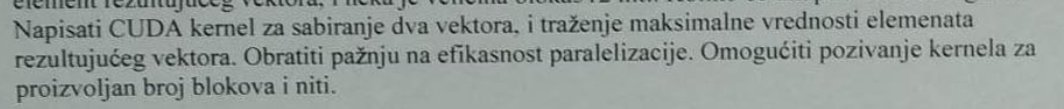

Sta znaci proizvoljan broj blokova i niti?
<br>
Da li idemo do 1024 niti
<br>
Da li treba podeliti onda na tajlove koji ce biti dimenzije 1024 kao maksimalnog broja niti
<br>
Da li treba poodeliti dimenziju niza sa promenljivom numberOfThreads koja moze da se menja, kako bi se ustanovilo koliko je blokova potrebno za taj konkretan broj niti koji se koristi

In [ ]:
%%cu
#include <iostream>

using namespace std;
const int numOfThreads = 12;



__global__ void func(int* A, int *B, int* R, int n, int *globalMax)
{
   extern __shared__ int res[];
   __shared__ int blockMax[numOfThreads];

  int index = blockIdx.x * blockDim.x + threadIdx.x;
  int localMax = INT_MIN;

  if(index < n)
  {
      for(int i=index; i<n; i+= gridDim.x * blockDim.x)
      {
          res[index] = A[index] + B[index];
          if(res[index] > localMax)
            localMax = res[index];
      }

      blockMax[threadIdx.x] = localMax;
  }

   __syncthreads();

  if(index < n)
  {
      for(int i=index; i<n; i+= gridDim.x * blockDim.x)
        R[index] = res[index];
  }

  for (int stride = blockDim.x / 2; stride - 1 != 0; stride = (stride-1) / 2 + 1)
  {
      __syncthreads();
      if (threadIdx.x < stride)
      {
          int currentMax = blockMax[threadIdx.x];
          int otherMax = blockMax[threadIdx.x + stride];
          if (otherMax > currentMax)
              blockMax[threadIdx.x] = otherMax;
      }
  }

    if (threadIdx.x == 0)
    {
        atomicMax(globalMax, blockMax[0]);
    }

}

int main()
{
    int n = 15;
    int* A = new int[n];
    int* B = new int[n];
    int* R = new int[n];
    int globalMax = INT_MIN;

    int* devA;
    int* devB;
    int* devR;
    int* devGlobalMax;

    cudaMalloc(&devA, n*sizeof(int));
    cudaMalloc(&devB, n*sizeof(int));
    cudaMalloc(&devR, n*sizeof(int));
    cudaMalloc(&devGlobalMax, sizeof(int));

    for(int i=0;i<n;i++)
    {
        A[i] = i;
        B[i] = i + 1;
    }

    cudaMemcpy(devA, A, n*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devB, B, n*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devGlobalMax, &globalMax, sizeof(int), cudaMemcpyHostToDevice);

    func<<<(n - 1)/ numOfThreads + 1, numOfThreads, n * sizeof(int)>>>(devA, devB, devR, n, devGlobalMax);

    cudaMemcpy(R, devR, n*sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(&globalMax, devGlobalMax, sizeof(int), cudaMemcpyDeviceToHost);

    cout << "A" << endl;
    for(int i=0;i<n;i++)
    {
        cout << A[i] << " ";
    }
    cout << endl;

    cout << "B" << endl;
    for(int i=0;i<n;i++)
    {
        cout << B[i] << " ";
    }
    cout << endl;

    cout << "Res" << endl;
    for(int i=0;i<n;i++)
    {
        cout << R[i] << " ";
    }
    cout << endl;

    cout << "Max " << globalMax << endl;

    delete[] A;
    delete[] B;
    delete[] R;

    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devR);
    cudaFree(devGlobalMax);
}

A
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
B
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Res
1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 
Max 29



In [ ]:

%%cu
#include <iostream>
using namespace std;

const int numOfThreads = 4;
const int n = 8;

__global__ void sumVectors(int *a, int *b, int *c, int *tmp, int n)
{
    extern __shared__ int res[];
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    if (index < n)
    {
        res[threadIdx.x] = a[index] + b[index];
        c[index] = res[threadIdx.x];
        __syncthreads();

        for (int s = blockDim.x / 2; s > 0; s >>= 1)
        {
            if (threadIdx.x < s)
                if (res[threadIdx.x + s] > res[threadIdx.x])
                    res[threadIdx.x] = res[threadIdx.x + s];

            __syncthreads();
        }
        if (threadIdx.x == 0)
        {
            tmp[blockIdx.x] = res[0];
        }
    }
}

__global__ void reduce(int *tmp, int n, int *max)
{
    extern __shared__ int res[];
    int index = threadIdx.x;
    if (index < n)
    {
        res[index] = tmp[index];

        __syncthreads();

        for (int s = blockDim.x / 2; s > 0; s >>= 1)
        {
            if (index < s)
                if (res[index + s] > res[index])
                    res[index] = res[index + s];
            __syncthreads();
        }

        if(index == 0)
        {
            *max = res[0];
        }
    }
}

int main()
{
    int numOfBlocks = (n - 1) / numOfThreads + 1;
    int *a = new int[n];
    int *b = new int[n];
    int *c = new int[n];
    int *tmp = new int[numOfBlocks];
    int max = 0;

    int *devA, *devB, *devC, *devMax, *devTmp;

    cudaMalloc(&devA, n * sizeof(int));
    cudaMalloc(&devB, n * sizeof(int));
    cudaMalloc(&devC, n * sizeof(int));
    cudaMalloc(&devTmp, numOfBlocks * sizeof(int));
    cudaMalloc(&devMax, sizeof(int));

    for (int i = 0; i < n; i++)
    {
        a[i] = i;
        b[i] = i + 1;
    }

    cudaMemcpy(devA, a, n * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(devB, b, n * sizeof(int), cudaMemcpyHostToDevice);

    sumVectors<<<numOfBlocks, numOfThreads, numOfThreads * sizeof(int)>>>(devA, devB, devC, devTmp, n);

    cudaMemcpy(c, devC, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(tmp, devTmp, numOfBlocks * sizeof(int), cudaMemcpyDeviceToHost);

    // podrazumevamo da n nije vece od num threads

    if (numOfBlocks == 1)
    {
        max = tmp[0];
    }
    else
    {
        reduce<<<1, numOfBlocks, numOfBlocks * sizeof(int)>>>(devTmp, numOfBlocks, devMax);
        cudaMemcpy(&max, devMax, sizeof(int), cudaMemcpyDeviceToHost);
    }

    cout << "C" << endl;
    for (int i = 0; i < n; i++)
    {
        cout << c[i] << " ";
    }
    cout << endl;

    cout << "Tmp" << endl;
    for (int i = 0; i < numOfBlocks; i++)
    {
        cout << tmp[i] << " ";
    }
    cout << endl;

    cout << "Max " << max << endl;

    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devC);
    cudaFree(devMax);
    cudaFree(devTmp);

    delete[] a;
    delete[] b;
    delete[] c;
    delete[] tmp;
}

C
1 3 5 7 9 11 13 15 
Tmp
7 15 
Max 15



In [ ]:
%%cu
#include <iostream>

using namespace std;
const int numOfThreads = 256;

__device__ float operatorX(int a, int b, float c)
{
    return a*c-b;
}
__global__ void calculateVector(float* A, float* vector, int n, float c)
{
    extern __shared__ float sum[];

    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int rowToProcess = index / 2;

    if(rowToProcess < n)
    {
        sum[index] = 0;
        for(int i = index % 2; i < n; i += 2)
        {
           float result = operatorX(rowToProcess, i, c);
           A[rowToProcess*n + i] = result;
           sum[index] += result;
        }

        __syncthreads();

        if(index % 2 == 0)
          vector[rowToProcess] = sum[index] + sum[index + 1];
    }
}

int main()
{
    int n = 4;
    float* A = new float[n*n];
    float* V = new float[n];
    float c = 2;

    float* devA;
    float* devV;

    cudaMalloc(&devA, n*n*sizeof(float));
    cudaMalloc(&devV, n*sizeof(float));

    int blockNum = (n - 1)/ numOfThreads + 1;
    if(blockNum > 256)
      blockNum = 256;

    calculateVector<<<blockNum, numOfThreads, numOfThreads * sizeof(float)>>>(devA, devV, n, c);

    cudaMemcpy(A, devA, n*n*sizeof(float), cudaMemcpyDeviceToHost);
    cudaMemcpy(V, devV, n*sizeof(float), cudaMemcpyDeviceToHost);

    cout << "A" << endl;
    for(int i=0;i<n;i++)
    {
        for(int j=0;j<n;j++)
          cout << A[i*n + j] << " ";
        cout << endl;
    }

    cout << "V" << endl;
    for(int i=0;i<n;i++)
    {
        cout << V[i] << " ";
    }
    cout << endl;

    delete[] A;
    delete[] V;

    cudaFree(devA);
    cudaFree(devV);
}

A
0 -1 -2 -3 
2 1 0 -1 
4 3 2 1 
6 5 4 3 
V
-6 2 10 18 



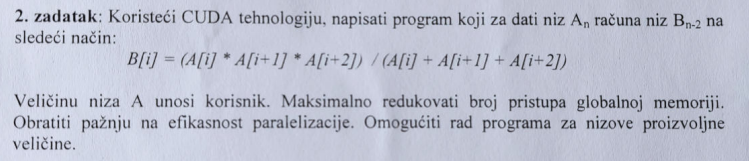

In [ ]:

%%cu
#include <iostream>
    using namespace std;

const int numOfThreads = 2;
const int n = 8;

__global__ void calculateVector(int *a, int *b, int* c, int n)
{
    extern __shared__ int aPart[];
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int tmp = n / (numOfThreads * gridDim.x);
    index *= tmp; // every thread will do n/numOfThreads elements

    for (int i = index; i < tmp + index; i++)
    {
        aPart[i % (n / gridDim.x)] = a[index];
        c[i] = aPart[i % (n / gridDim.x)];
    }

    __syncthreads();

    if (index < n - 2)
    {
        for (int i = index; i < tmp + index; i++)
        {
            if (i % (n / gridDim.x) == (n / gridDim.x) - 2)
                b[i] = aPart[i] + aPart[i + 1] + a[i + 2];
            else if (i % (n / gridDim.x) == (n / gridDim.x) - 1)
                b[i] = aPart[i] + a[i + 1] + a[i + 2];
            else
                b[i] = aPart[i] + aPart[i + 1] + aPart[i + 2];
        }
    }
}

int main()
{
    int numOfBlocks = (n / 4 - 1) / numOfThreads + 1;
    int *a = new int[n];
    int *c = new int[n];
    int *b = new int[n - 2];

    int *devA, *devB, *devC;

    cudaMalloc(&devA, n * sizeof(int));
    cudaMalloc(&devC, n * sizeof(int));
    cudaMalloc(&devB, (n - 2) * sizeof(int));

    for (int i = 0; i < n; i++)
    {
        a[i] = i;
    }

    cudaMemcpy(devA, a, n * sizeof(int), cudaMemcpyHostToDevice);

    calculateVector<<<numOfBlocks, numOfThreads, (n / numOfBlocks) * sizeof(int)>>>(devA, devB, devC, n);

    cudaMemcpy(b, devB, (n - 2) * sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(c, devC, n * sizeof(int), cudaMemcpyDeviceToHost);

    cout << "C" << endl;
    for (int i = 0; i < n; i++)
    {
        cout << c[i] << " ";
    }
    cout << endl;

    cout << "B" << endl;
    for (int i = 0; i < n - 2; i++)
    {
        cout << b[i] << " ";
    }
    cout << endl;

    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devC);

    delete[] a;
    delete[] b;
    delete[] c;
}

C
0 0 0 0 4 4 4 4 
B
0 0 4 8 12 12 



In [11]:
%%cu
#include <iostream>
    using namespace std;

const int n = 8;
const int numOfThreads = 20;

__global__ void extractDiagonalElements(int *A, int *vector, int n)
{
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    while (index < n)
    {
        vector[index] = A[index * n + index];
        index += gridDim.x * blockDim.x;
    }
}

__global__ void extractMin(int *vector, int *min, int n)
{
    extern __shared__ int result[];

    int index = threadIdx.x;
    if (index < n)
    {
        result[index] = vector[index];

        __syncthreads();

        for (int s = blockDim.x; s > 0; s >>= 1)
        {
            if (index < s)
            {
                if (result[index + s] < result[index])
                    result[index] = result[index + s];
            }
            __syncthreads();
        }

        if (index == 0)
            *min = result[0];
    }
}

int main()
{
    int *A = new int[n * n];
    int *diagonalVector = new int[n];
    int min = 0;

    int *devA, *devVector, *devMin;
    cudaMalloc(&devA, n * n * sizeof(int));
    cudaMalloc(&devVector, n * sizeof(int));
    cudaMalloc(&devMin, sizeof(int));

    for (int i = 0; i < n * n; i++)
        A[i] = -i;

    cudaMemcpy(devA, A, n * n * sizeof(int), cudaMemcpyHostToDevice);

    extractDiagonalElements<<<(n - 1) / numOfThreads + 1, numOfThreads>>>(devA, devVector, n);

    extractMin<<<1, numOfThreads, numOfThreads * sizeof(int)>>>(devVector, devMin, n);

    cudaMemcpy(&min, devMin, sizeof(int), cudaMemcpyDeviceToHost);

    cout << "Minimum is " << min << endl;

    delete[] A;
    delete[] diagonalVector;

    cudaFree(devA);
    cudaFree(devVector);
    cudaFree(devMin);
}

Minimum is -63

